# Portfolio Optimization Visualization

This notebook provides interactive visualizations for the portfolio optimization results, with special focus on equity curves.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plot style
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

## Load Optimization Results

First, we'll load data from the results directory.

In [2]:
# Define results directory
results_dir = 'results'

# Check if directory exists
if not os.path.exists(results_dir):
    print(f"Results directory '{results_dir}' not found. Run main.py first to generate results.")
else:
    # Load portfolio weights
    try:
        pso_weights = pd.read_csv(os.path.join(results_dir, 'pso_weights.csv'))
        traditional_weights = pd.read_csv(os.path.join(results_dir, 'traditional_weights.csv'))
        print(f"Loaded portfolio weights from {results_dir}")
    except FileNotFoundError:
        print("Weight files not found. Run main.py first to generate results.")

Loaded portfolio weights from results


## Load Stock Data

Now we'll load the stock data from the 5m directory, similar to what's done in the main script.

In [3]:
# Import our data processor
import sys
sys.path.append('.')
from src.data.data_processor import DataProcessor

# Initialize data processor with path to data directory
data_dir = '5m'
processor = DataProcessor(data_dir)

# Load stock data - you can adjust the number of stocks to include
n_stocks = 30
processor.load_stock_data(limit=n_stocks)

# Calculate returns
processor.calculate_returns()

# Calculate daily returns
daily_returns = processor.calculate_daily_returns()

# Split data into training and testing sets
train_data, test_data = processor.split_train_test(test_ratio=0.2)
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Loading stock data from 5m
Loaded 360ONE data: 15267 rows
Loaded 3MINDIA data: 15267 rows
Loaded AADHARHFC data: 8491 rows
Loaded AARTIIND data: 15267 rows
Loaded AARTIPHARM data: 15267 rows
Loaded AAVAS data: 15267 rows
Loaded ABB data: 15267 rows
Loaded ABBOTINDIA data: 15267 rows
Loaded ABCAPITAL data: 15267 rows
Loaded ABDL data: 6070 rows
Loaded ABFRL data: 15267 rows
Loaded ABSLAMC data: 15267 rows
Loaded ACC data: 15267 rows
Loaded ACE data: 15267 rows
Loaded ACI data: 15267 rows
Loaded ADANIENSOL data: 15267 rows
Loaded ADANIENT data: 15267 rows
Loaded ADANIGREEN data: 15267 rows
Loaded ADANIPORTS data: 15267 rows
Loaded ADANIPOWER data: 15267 rows
Loaded ADVENZYMES data: 15267 rows
Loaded AEGISLOG data: 15267 rows
Loaded AETHER data: 15267 rows
Loaded AFFLE data: 15267 rows
Loaded AGI data: 15267 rows
Loaded AHLUCONT data: 15267 rows
Loaded AIAENG data: 15267 rows
Loaded AIIL data: 9621 rows
Loaded AJANTPHARM data: 15267 rows
Loaded AKUMS data: 4270 rows
Training data shape: (

## Load Portfolio Weights

Let's load portfolio weights from the results directory or recalculate them.

In [4]:
# We'll try to load saved weights, or recalculate if needed
from src.optimization.portfolio_theory import PortfolioOptimizer
from src.optimization.pso_optimizer import PSOPortfolioOptimizer

try:
    # Try to load PSO weights from results
    weights_df = pd.read_csv(os.path.join(results_dir, 'pso_weights.csv'))
    pso_weights = np.array(weights_df['Weight'])
    print("Loaded PSO weights from saved results")
    
    # Load traditional weights
    trad_weights_df = pd.read_csv(os.path.join(results_dir, 'traditional_weights.csv'))
    # Max Sharpe weights are in the second column
    max_sharpe_weights = np.array(trad_weights_df['Max Sharpe'])
    print("Loaded traditional weights from saved results")
    
except (FileNotFoundError, KeyError):
    print("Weights not found in results directory. Recalculating...")
    
    # Initialize portfolio optimizers
    risk_free_rate = 0.02  # 2% risk-free rate
    traditional_optimizer = PortfolioOptimizer(train_data, risk_free_rate=risk_free_rate)
    pso_optimizer = PSOPortfolioOptimizer(train_data, risk_free_rate=risk_free_rate, objective='sharpe')
    
    # Run PSO optimization
    pso_weights, _, _, _ = pso_optimizer.optimize(n_particles=50, iters=100)
    
    # Get traditional optimization weights
    max_sharpe_weights, _, _, _ = traditional_optimizer.max_sharpe()

# Equal weight portfolio
equal_weights = np.ones(len(train_data.columns)) / len(train_data.columns)

Loaded PSO weights from saved results
Loaded traditional weights from saved results


## Calculate Portfolio Returns and Equity Curves

Now we'll calculate the portfolio returns and equity curves for different strategies.

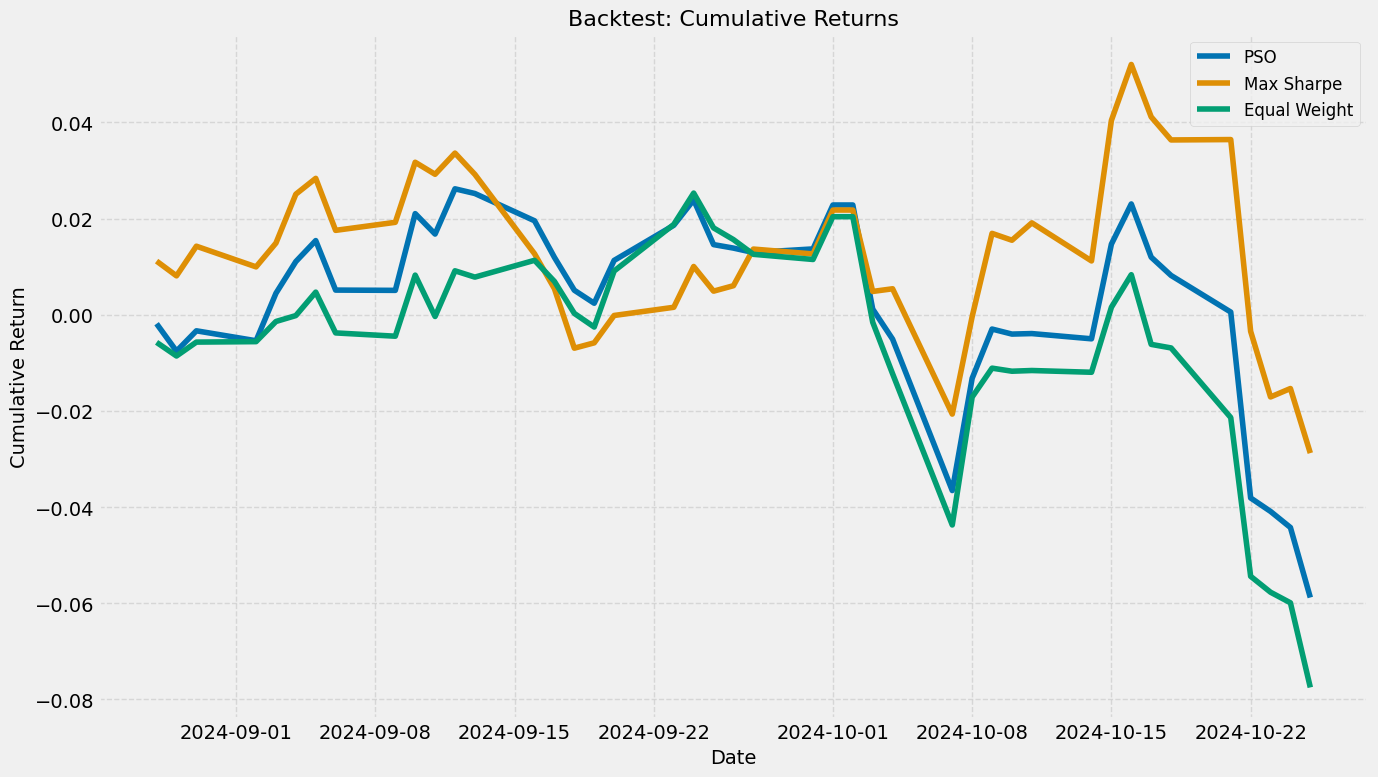


Final Cumulative Returns:
Max Sharpe: -2.88%
PSO: -5.88%
Equal Weight: -7.75%


In [5]:
# Calculate portfolio returns on test data
test_cumulative_returns = {}

# PSO portfolio
test_cumulative_returns['PSO'] = (test_data @ pso_weights).cumsum()

# Traditional portfolio (Max Sharpe)
test_cumulative_returns['Max Sharpe'] = (test_data @ max_sharpe_weights).cumsum()

# Equal weight portfolio
test_cumulative_returns['Equal Weight'] = (test_data @ equal_weights).cumsum()

# Convert to DataFrame for easier plotting
cumulative_returns_df = pd.DataFrame(test_cumulative_returns)

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for col in cumulative_returns_df.columns:
    plt.plot(cumulative_returns_df.index, cumulative_returns_df[col], label=col)
plt.title('Backtest: Cumulative Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate ending values
final_returns = cumulative_returns_df.iloc[-1].sort_values(ascending=False)
print("\nFinal Cumulative Returns:")
for strategy, ret in final_returns.items():
    print(f"{strategy}: {ret:.2%}")

## Plot Interactive Portfolio Equity Curve

Now we'll create an interactive equity curve that shows the growth of an initial investment.

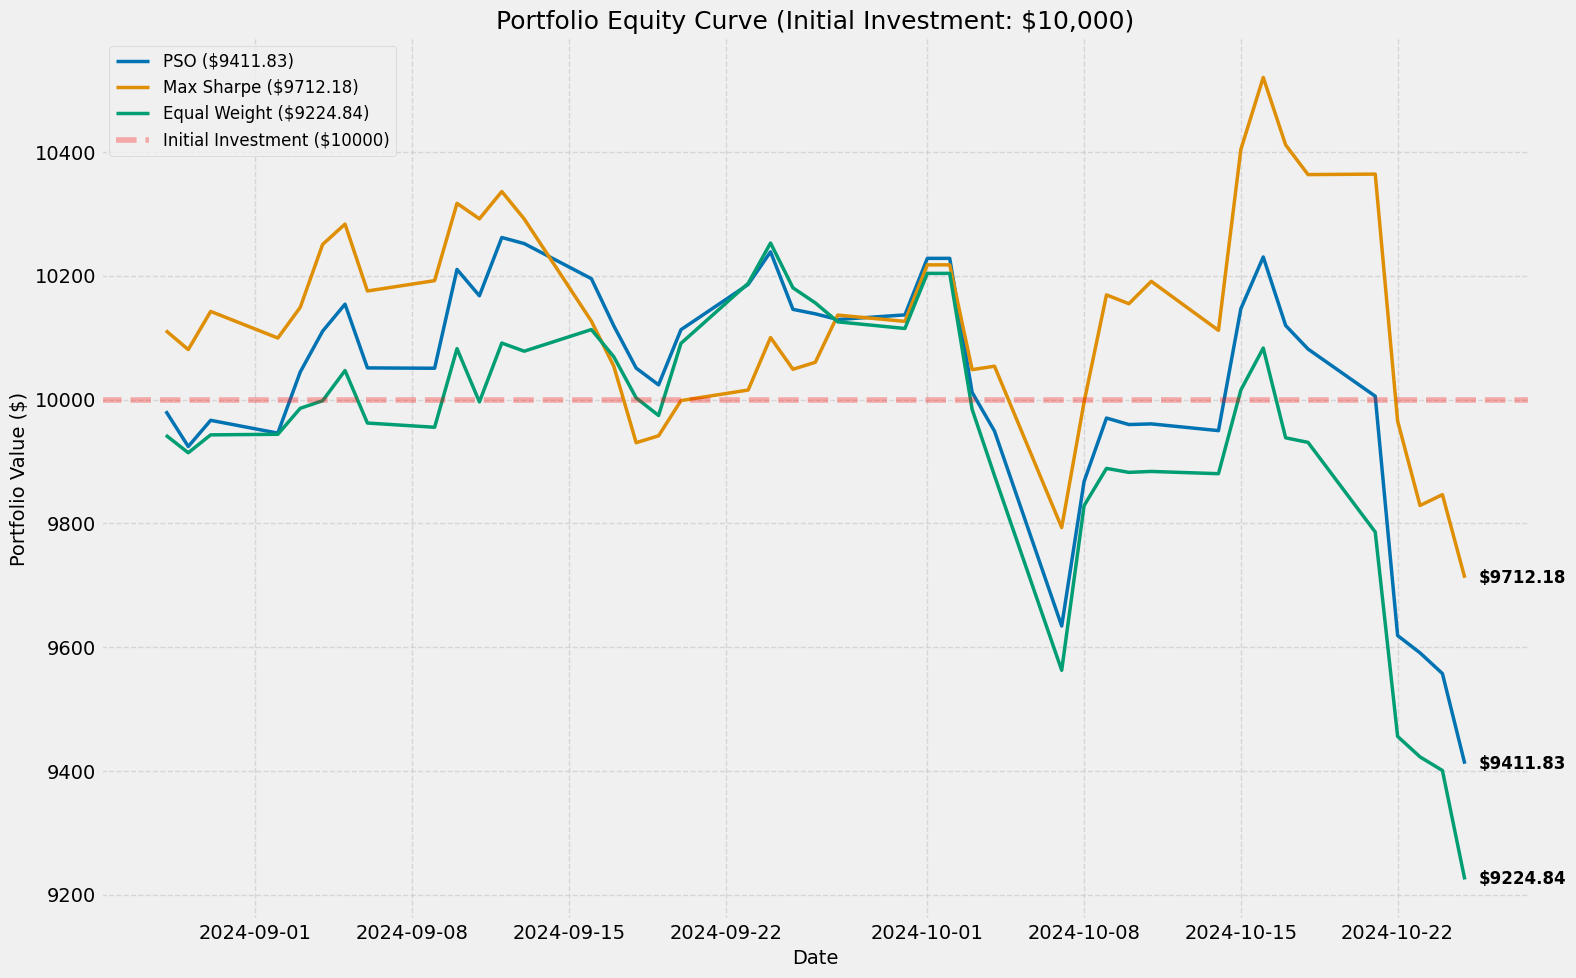


Portfolio Performance Summary:


,Initial Investment,Final Value,Total Return
PSO,"$10,000",$9411.83,-5.88%
Max Sharpe,"$10,000",$9712.18,-2.88%
Equal Weight,"$10,000",$9224.84,-7.75%


In [6]:
# Define initial investment amount
initial_investment = 10000  # $10,000

# Calculate portfolio values over time
portfolio_values = {}
for name, returns in test_cumulative_returns.items():
    portfolio_values[name] = initial_investment * (1 + returns)

# Convert to DataFrame
portfolio_values_df = pd.DataFrame(portfolio_values)

# Create more detailed equity curve plot
plt.figure(figsize=(16, 10))

# Plot equity curves with enhanced styling
for strategy in portfolio_values_df.columns:
    plt.plot(portfolio_values_df.index, portfolio_values_df[strategy], 
             linewidth=2.5, label=f"{strategy} (${portfolio_values_df[strategy].iloc[-1]:.2f})")

# Add horizontal line for initial investment
plt.axhline(y=initial_investment, color='r', linestyle='--', alpha=0.3, 
            label=f"Initial Investment (${initial_investment})") 

# Add title and labels
plt.title(f'Portfolio Equity Curve (Initial Investment: ${initial_investment:,})', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)

# Customize appearance
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='upper left')

# Add annotations for final values
for strategy in portfolio_values_df.columns:
    final_value = portfolio_values_df[strategy].iloc[-1]
    plt.annotate(f"${final_value:.2f}", 
                 xy=(portfolio_values_df.index[-1], final_value),
                 xytext=(10, 0), textcoords='offset points', 
                 ha='left', va='center',
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Table of final values and returns
final_values = {strategy: value.iloc[-1] for strategy, value in portfolio_values.items()}
total_returns = {strategy: (value.iloc[-1] / initial_investment - 1) * 100 for strategy, value in portfolio_values.items()}

results_df = pd.DataFrame({
    'Initial Investment': [f"${initial_investment:,}" for _ in range(len(final_values))],
    'Final Value': [f"${value:.2f}" for value in final_values.values()],
    'Total Return': [f"{return_pct:.2f}%" for return_pct in total_returns.values()]
}, index=final_values.keys())

results_df.sort_values('Final Value', ascending=False, key=lambda x: [float(val.replace('$', '').replace(',', '')) for val in x])

print("\nPortfolio Performance Summary:")
display(results_df)

## Performance Metrics Analysis

Let's calculate additional performance metrics for the different strategies.

In [7]:
# Calculate daily returns from portfolio values
daily_portfolio_returns = portfolio_values_df.pct_change().dropna()

# Calculate performance metrics
metrics = {
    'Total Return (%)': [],
    'Annualized Return (%)': [],
    'Annualized Volatility (%)': [],
    'Sharpe Ratio': [],
    'Max Drawdown (%)': [],
}

# Risk-free rate (annual)
risk_free_rate = 0.02
# Convert to daily
daily_risk_free = (1 + risk_free_rate) ** (1/252) - 1

for strategy in portfolio_values_df.columns:
    # Get returns
    returns = daily_portfolio_returns[strategy]
    
    # Total return
    total_return = (portfolio_values_df[strategy].iloc[-1] / portfolio_values_df[strategy].iloc[0] - 1) * 100
    metrics['Total Return (%)'].append(total_return)
    
    # Annualized return
    n_days = len(returns)
    annualized_return = ((1 + total_return/100) ** (252/n_days) - 1) * 100
    metrics['Annualized Return (%)'].append(annualized_return)
    
    # Annualized volatility
    annualized_vol = returns.std() * np.sqrt(252) * 100
    metrics['Annualized Volatility (%)'].append(annualized_vol)
    
    # Sharpe ratio
    sharpe = (annualized_return/100 - risk_free_rate) / (annualized_vol/100)
    metrics['Sharpe Ratio'].append(sharpe)
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max - 1) * 100
    max_drawdown = drawdown.min()
    metrics['Max Drawdown (%)'].append(max_drawdown)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics, index=portfolio_values_df.columns)

# Format the metrics for display
display_metrics = metrics_df.copy()
for col in ['Total Return (%)', 'Annualized Return (%)', 'Annualized Volatility (%)', 'Max Drawdown (%)']:
    display_metrics[col] = display_metrics[col].map(lambda x: f"{x:.2f}%")
display_metrics['Sharpe Ratio'] = display_metrics['Sharpe Ratio'].map(lambda x: f"{x:.2f}")

print("\nPortfolio Performance Metrics:")
display(display_metrics)

# Sort by Sharpe Ratio
metrics_df_sorted = metrics_df.sort_values('Sharpe Ratio', ascending=False)
print("\nStrategies ranked by Sharpe Ratio:")
for idx, row in enumerate(metrics_df_sorted.iterrows()):
    strategy, metrics = row
    print(f"{idx+1}. {strategy}: Sharpe Ratio = {metrics['Sharpe Ratio']:.2f}, Return = {metrics['Annualized Return (%)']:.2f}%, Risk = {metrics['Annualized Volatility (%)']:.2f}%")


Portfolio Performance Metrics:


,Total Return (%),Annualized Return (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%)
PSO,-5.71%,-29.70%,18.62%,-1.70,-8.28%
Max Sharpe,-3.95%,-21.48%,19.05%,-1.23,-7.68%
Equal Weight,-7.22%,-36.21%,18.21%,-2.10,-10.03%



Strategies ranked by Sharpe Ratio:
1. Max Sharpe: Sharpe Ratio = -1.23, Return = -21.48%, Risk = 19.05%
2. PSO: Sharpe Ratio = -1.70, Return = -29.70%, Risk = 18.62%
3. Equal Weight: Sharpe Ratio = -2.10, Return = -36.21%, Risk = 18.21%


## Visualize Drawdowns

Let's analyze and visualize the drawdowns for each portfolio strategy.

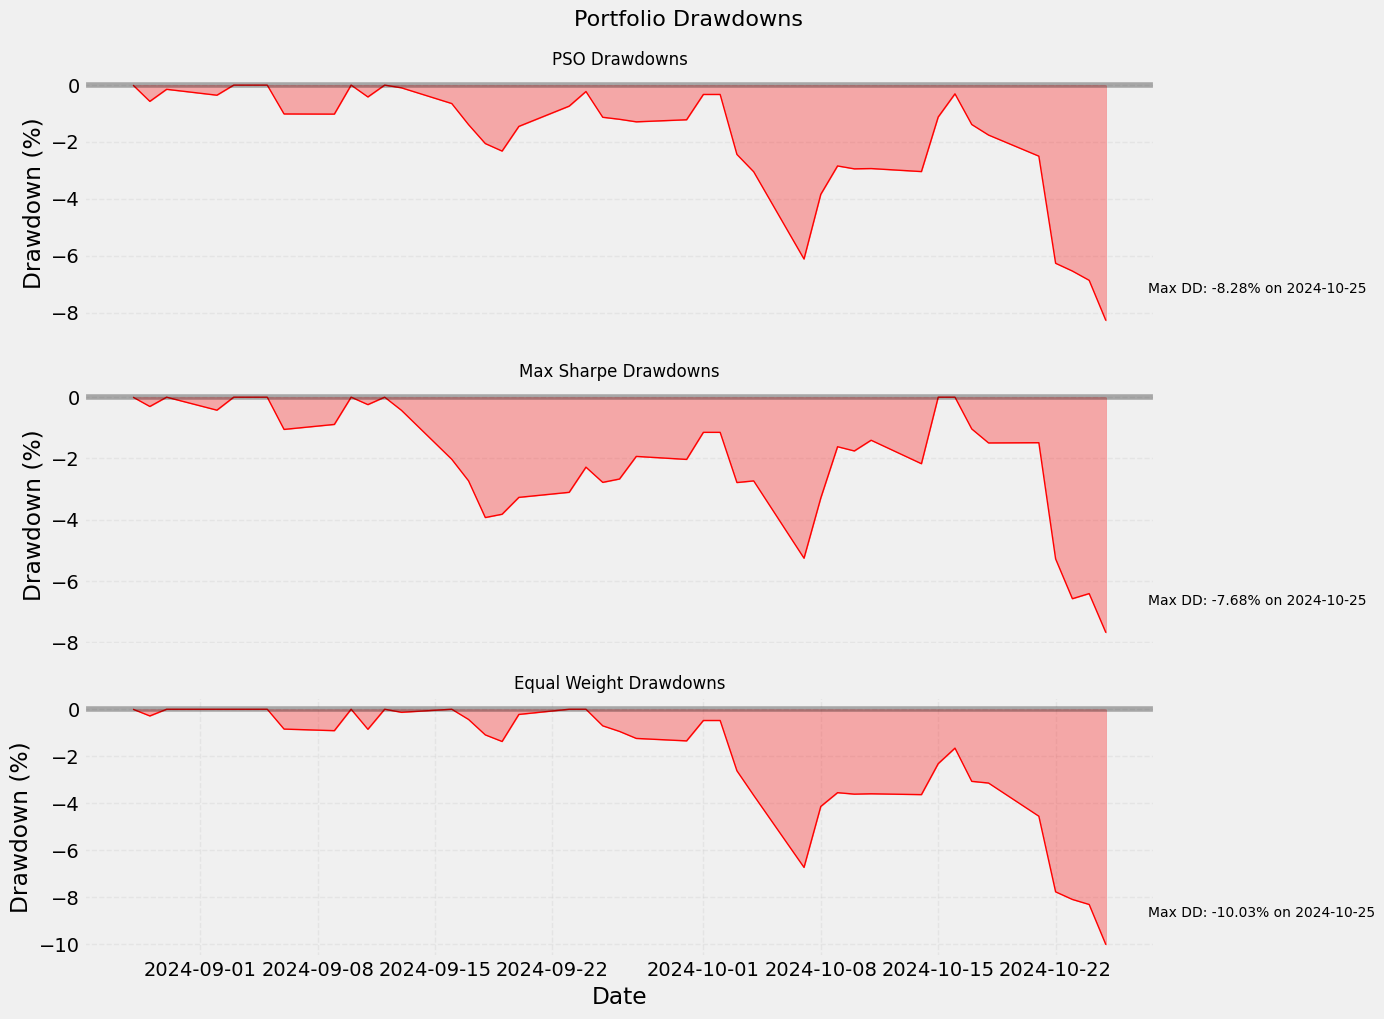


Drawdown Analysis:


,Max Drawdown (%),Average Drawdown (%),Days in Drawdown,Recovery Days
PSO,-8.28%,-2.17%,37,Not recovered
Max Sharpe,-7.68%,-2.56%,34,Not recovered
Equal Weight,-10.03%,-2.87%,32,Not recovered


In [8]:
# Calculate drawdowns for each strategy
drawdowns = {}

plt.figure(figsize=(14, 10))

for i, strategy in enumerate(portfolio_values_df.columns):
    # Get portfolio values
    values = portfolio_values_df[strategy]
    
    # Calculate running maximum
    running_max = values.cummax()
    
    # Calculate drawdown as percentage
    drawdown = ((values / running_max) - 1) * 100
    drawdowns[strategy] = drawdown
    
    # Plot in a separate subplot
    plt.subplot(len(portfolio_values_df.columns), 1, i+1)
    plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
    plt.plot(drawdown.index, drawdown, color='red', linewidth=1)
    
    # Add horizontal line at 0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add annotation for maximum drawdown
    max_dd = drawdown.min()
    max_dd_date = drawdown.idxmin()
    plt.annotate(f"Max DD: {max_dd:.2f}% on {max_dd_date.strftime('%Y-%m-%d')}",
                xy=(max_dd_date, max_dd),
                xytext=(30, 20), 
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'),
                fontsize=10)
    
    plt.title(f"{strategy} Drawdowns", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylabel('Drawdown (%)')
    
    # Only show x-axis for the last subplot
    if i < len(portfolio_values_df.columns) - 1:
        plt.xticks([])

plt.xlabel('Date')
plt.tight_layout()
plt.suptitle('Portfolio Drawdowns', fontsize=16, y=1.02)
plt.show()

# Convert drawdowns to DataFrame
drawdowns_df = pd.DataFrame(drawdowns)

# Summary of drawdowns
drawdown_summary = pd.DataFrame({
    'Max Drawdown (%)': [drawdowns_df[col].min() for col in drawdowns_df.columns],
    'Average Drawdown (%)': [drawdowns_df[col][drawdowns_df[col] < 0].mean() for col in drawdowns_df.columns],
    'Days in Drawdown': [(drawdowns_df[col] < 0).sum() for col in drawdowns_df.columns],
    'Recovery Days': [None for _ in drawdowns_df.columns]  # Will calculate this below
}, index=drawdowns_df.columns)

# Calculate recovery days (from max drawdown)
for col in drawdowns_df.columns:
    max_dd_idx = drawdowns_df[col].idxmin()
    # Find first day after max drawdown where we reach 0 again (full recovery)
    after_max_dd = drawdowns_df.loc[max_dd_idx:, col]
    recovery_dates = after_max_dd[after_max_dd >= 0]
    if len(recovery_dates) > 0:
        recovery_days = (recovery_dates.index[0] - max_dd_idx).days
        drawdown_summary.loc[col, 'Recovery Days'] = recovery_days
    else:
        drawdown_summary.loc[col, 'Recovery Days'] = "Not recovered"

# Format for display
display_dd_summary = drawdown_summary.copy()
for col in ['Max Drawdown (%)', 'Average Drawdown (%)']:
    display_dd_summary[col] = display_dd_summary[col].map(lambda x: f"{x:.2f}%")

print("\nDrawdown Analysis:")
display(display_dd_summary)

## Export Results to PDF

Let's export the key visualizations to PDF for reporting.

In [9]:
from matplotlib.backends.backend_pdf import PdfPages

def save_figures_to_pdf(filename='portfolio_analysis.pdf'):
    with PdfPages(filename) as pdf:
        # Equity Curve
        plt.figure(figsize=(11, 8.5))
        for strategy in portfolio_values_df.columns:
            plt.plot(portfolio_values_df.index, portfolio_values_df[strategy], 
                    linewidth=2, label=f"{strategy} (${portfolio_values_df[strategy].iloc[-1]:.2f})")
        plt.axhline(y=initial_investment, color='r', linestyle='--', alpha=0.3, 
                    label=f"Initial Investment (${initial_investment})")
        plt.title(f'Portfolio Equity Curve (Initial Investment: ${initial_investment:,})', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Portfolio Value ($)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        
        # Drawdowns
        plt.figure(figsize=(11, 8.5))
        for i, strategy in enumerate(portfolio_values_df.columns):
            plt.subplot(len(portfolio_values_df.columns), 1, i+1)
            plt.fill_between(drawdowns_df.index, drawdowns_df[strategy], 0, color='red', alpha=0.3)
            plt.plot(drawdowns_df.index, drawdowns_df[strategy], color='red', linewidth=1)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.title(f"{strategy} Drawdowns", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.ylabel('Drawdown (%)')
            if i < len(portfolio_values_df.columns) - 1:
                plt.xticks([])
        plt.xlabel('Date')
        plt.tight_layout()
        plt.suptitle('Portfolio Drawdowns', fontsize=16, y=1.02)
        pdf.savefig()
        plt.close()
        
        # Add metrics table as a figure
        plt.figure(figsize=(11, 8.5))
        plt.axis('off')
        plt.title('Portfolio Performance Metrics', fontsize=16)
        
        # Combine metrics and drawdown data for the table
        table_data = []
        table_data.append(['Strategy', 'Total Return', 'Ann. Return', 'Ann. Volatility', 'Sharpe', 'Max Drawdown'])
        
        for strategy in metrics_df.index:
            table_data.append([
                strategy,
                f"{metrics_df.loc[strategy, 'Total Return (%)']:.2f}%",
                f"{metrics_df.loc[strategy, 'Annualized Return (%)']:.2f}%",
                f"{metrics_df.loc[strategy, 'Annualized Volatility (%)']:.2f}%",
                f"{metrics_df.loc[strategy, 'Sharpe Ratio']:.2f}",
                f"{metrics_df.loc[strategy, 'Max Drawdown (%)']:.2f}%"
            ])
        
        plt.table(cellText=table_data[1:],
                 colLabels=table_data[0],
                 cellLoc='center',
                 loc='center',
                 colColours=['#f5f5f5']*len(table_data[0]),
                 bbox=[0.1, 0.3, 0.8, 0.5])
        
        plt.text(0.5, 0.15, 
                 f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}\n"
                 f"Backtest Period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}\n"
                 f"Initial Investment: ${initial_investment:,}",
                 ha='center',
                 fontsize=12)
        
        pdf.savefig()
        plt.close()
        
    print(f"PDF report saved to {filename}")

# Generate the PDF report
save_figures_to_pdf()

PDF report saved to portfolio_analysis.pdf
